# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#выгружаем данные для работы
datagen = ImageDataGenerator(rescale=1/255)
data_classes=pd.read_csv('/datasets/faces/labels.csv')
full_datagen = datagen.flow_from_dataframe(dataframe=data_classes,
                                          directory ='/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=10)

Found 7591 validated image filenames.


Функция flow_from_dataframe() выше отразила, что было обнаружено 7591 изображение. Посмотрим на размер датасета столько ли у нас строк

In [3]:
data_classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер классов сошелся с количеством изображений. Пропусков нет. Типы данных в нужном формате. Выборки готовы для анализа и проведения над ними операций.

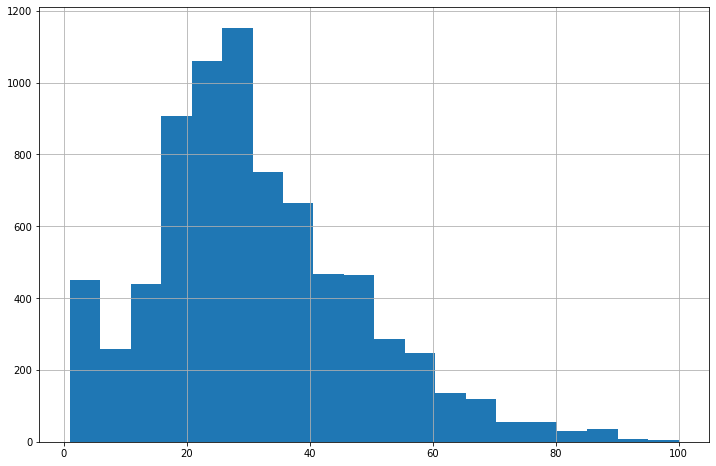

In [4]:
# посмотрим распределение по возрасту. Построим гистограмму
plt.figure(figsize=(12,8))
plt.hist(data_classes['real_age'], bins=20)
plt.grid()

По графику видно, что основная возрастная категория в представленном датасете это люди от 18 до 30 лет. На них пришлась примерно одна треть всей выборки. Немного есть людей за 80 и ощутимое количество лиц младше 10, что интересно так как дети до 6 не могут быть покупателями.

In [5]:
data_classes[data_classes['real_age']<7].count()

file_name    518
real_age     518
dtype: int64

Для задачи по предложению товаров поупателям данная категория являлась бы не нужной и ее можно было бы удалить из выборки, однако вторая задача гласит, чтобы не допускалась продажа алкоголя лицам младше 18, поэтому эти данные можно оставить.

In [6]:
# посмотрим несколько изображений
pictures, target = next(full_datagen)

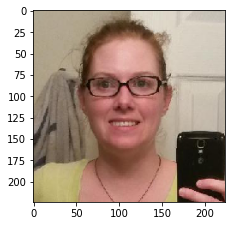

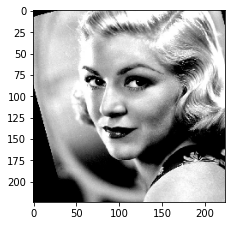

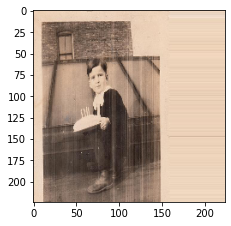

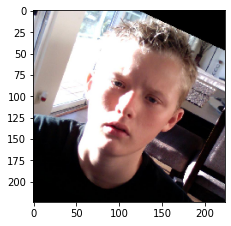

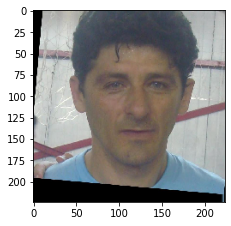

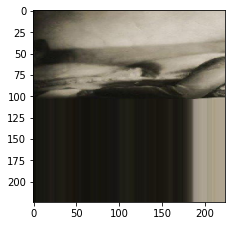

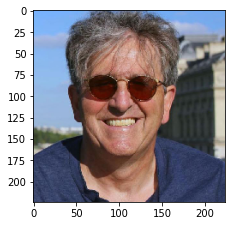

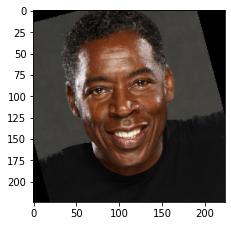

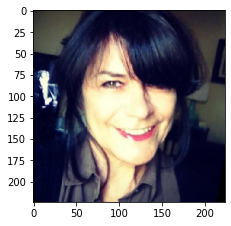

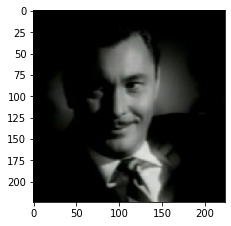

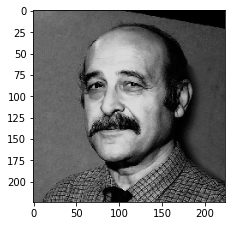

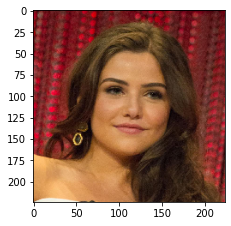

In [7]:
for i in range(12):
    plt.figure(figsize=(10,50))
    plt.subplot(12,2,i+1)
    plt.imshow(pictures[i])

Датасет представлен изображениями людей различного возраста. Сами изображения имеют различное каччество, что делает обучение модели более сложным и повышает шанс достоверности прогнозов.

## Обучение модели

Ниже предстален код обучения модели нейронной сети, который запускался с помощью GPU-серверов Яндекса.

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    data_classes=pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                      horizontal_flip=False)            
                                      
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           subset='training',                
                                           seed=10)
    return train_datagen_flow

def load_test(path):
    data_classes=pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=16,
                                           class_mode='raw',
                                           subset ='validation',
                                           seed=10)
    return test_datagen_flow



def create_model(input_shape):
    optimizer=Adam(lr=0.0005)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
      
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=19,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
                
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 

Результат выполнения кода

Train for 356 steps, validate for 119 steps
Epoch 1/19
2022-06-08 06:16:02.714917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-08 06:16:03.009433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 211.7318 - mae: 10.9966 - val_loss: 420.2592 - val_mae: 15.4771
Epoch 2/19
356/356 - 38s - loss: 124.9652 - mae: 8.5606 - val_loss: 261.9538 - val_mae: 12.1682
Epoch 3/19
356/356 - 38s - loss: 91.8732 - mae: 7.3299 - val_loss: 194.7638 - val_mae: 11.3759
Epoch 4/19
356/356 - 38s - loss: 66.0234 - mae: 6.2450 - val_loss: 139.6988 - val_mae: 8.8920
Epoch 5/19
356/356 - 38s - loss: 45.8460 - mae: 5.2043 - val_loss: 97.1681 - val_mae: 7.3594
Epoch 6/19
356/356 - 38s - loss: 31.0162 - mae: 4.2913 - val_loss: 104.6903 - val_mae: 7.8035
Epoch 7/19
356/356 - 37s - loss: 23.2934 - mae: 3.7542 - val_loss: 97.2648 - val_mae: 7.6929
Epoch 8/19
356/356 - 37s - loss: 20.2622 - mae: 3.4670 - val_loss: 102.4448 - val_mae: 7.9178
Epoch 9/19
356/356 - 38s - loss: 17.0071 - mae: 3.1411 - val_loss: 89.6360 - val_mae: 7.0422
Epoch 10/19
356/356 - 38s - loss: 15.0130 - mae: 2.9779 - val_loss: 84.9613 - val_mae: 6.9051
Epoch 11/19
356/356 - 38s - loss: 13.1119 - mae: 2.7595 - val_loss: 85.9375 - val_mae: 7.0100
Epoch 12/19
356/356 - 37s - loss: 13.3808 - mae: 2.8055 - val_loss: 113.5940 - val_mae: 8.5061
Epoch 13/19
356/356 - 38s - loss: 14.9423 - mae: 2.9790 - val_loss: 92.5830 - val_mae: 7.2171
Epoch 14/19
356/356 - 38s - loss: 16.9776 - mae: 3.1775 - val_loss: 99.9663 - val_mae: 7.3978
Epoch 15/19
356/356 - 38s - loss: 21.1426 - mae: 3.4634 - val_loss: 136.8411 - val_mae: 9.0344
Epoch 16/19
356/356 - 38s - loss: 26.8081 - mae: 3.9129 - val_loss: 100.2977 - val_mae: 7.5060
Epoch 17/19
356/356 - 37s - loss: 17.4755 - mae: 3.2049 - val_loss: 87.3883 - val_mae: 7.0080
Epoch 18/19
356/356 - 37s - loss: 10.6558 - mae: 2.4842 - val_loss: 86.5089 - val_mae: 6.9635
Epoch 19/19
356/356 - 37s - loss: 6.8661 - mae: 1.9884 - val_loss: 78.4985 - val_mae: 6.6314
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 78.4985 - mae: 6.6314
Test MAE: 6.6314



## Анализ обученной модели

Обучалась модель не слишком долго в среднем минут 12-15. За базу построения модели была взята ReSnet50 предобученная на базе данных "Imagenet". Оптимизатором был выброн алгоритм Adan. Модель смогла справиться с поставленной задачей и достигнуть метрики МАЕ равной 6.6314, что означает что модель путает в среднем возраст на 6-7 лет. 